#  Context : 

Le but de ce notebook est d'explorer les données qui ont été créés en extrant les informations des dossiers gynéco / textes à la main et en les fusionnant avec les données receuil.

# Import : 

In [42]:
### Imports ###

# Data manipulation and other stuff : 
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
from matplotlib import pyplot as plt
import seaborn as sns
#import eli5 # eli5 not working anymore for current stable version of sklearn
from IPython.display import display

#import eli5

# Utils for NLP : 
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

# Utils for encoding : 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

# Utils for regression : 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

# Utils for Multilabel classification :
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Utils for Metrics calculation : 
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve
from metrics_utils import rewrite_keys, rapport_metrics_decision_tree, multilabel_multioutput_svc, multilabel_multioutput_LR, custom_show_weights

from sklearn.tree import plot_tree

# Multiclass/Multilabel preparation :
from sklearn.base import BaseEstimator, ClassifierMixin

# Custom preprocessing : 
from preprocess_NLP import preprocess_and_split

# Tensorflow/keras
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.utils import to_categorical
from keras.initializers import Constant
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, GridSearchCV
from skopt import BayesSearchCV

# Utils for encoding : 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

# Utils for regression : 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, make_scorer

# Utils for classification :
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier, plot_importance
from sklearn.ensemble import HistGradientBoostingClassifier

# Utils for Metrics calculation : 
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve
from metrics_utils import rewrite_keys, rapport_metrics_decision_tree
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

# Custom utils  
from Opti_utils.ML_utils import find_best_threshold, from_model_to_bst_trhld, custom_metrics, scores, compare_results,find_error
from Opti_utils.ML_utils import FP, TP, FN, TN, check_corr_col, filtre_list, fit_method, check_baseline, check_FP_FN, check_best_results
from Opti_utils.ML_utils import ML_opti_recueil, univariate_ml, sensi, speci, mix_sensi_speci, custom_metric
from Opti_utils.ML_utils import Binarisation, model_to_plot, clean_lists


# NLP 

## Load data : 

In [ ]:
### Choisir soit les données synthétisées où l'information des données gynéco a été priorisé, soit receuil
# (Priorisé = dans le cas d'un conflit entre gynéco et receuil, on prend soit l'info dans gynéco soit receuil)

data_select = 'receuil'     # 'gynéco', 'receuil', ou 'original'

recueil_imc  = pd.read_excel('Data/DATA_RAW/Recueil (1).xlsx').drop('Unnamed: 90', axis=1)
if data_select != 'original':
    columns_receuil_to_include = ['Numéro anonymat', 'age', 'imc', 'g', 'p', 'anapath.lusd','anapath.lusg','anapath.torus']
    recueil_imc = recueil_imc[columns_receuil_to_include]
recueil_imc = recueil_imc.rename(columns={'Numéro anonymat': 'Anonymisation'})
# Remplace les manquantes par un np.nan
recueil_imc.replace(['Na', 'NA', 'nan', 'Nan', 'NAN'], np.nan, inplace=True)

if data_select in ['gynéco', 'receuil']:
    df = pd.read_excel(f'Data/DATA_PROCESSED/data_synth_priorité_{data_select}.xlsx')
else:
    # If original data are used, we don't need the synthesized ones except to note the patients
    df = pd.read_excel(f'Data/DATA_PROCESSED/data_synth_priorité_gynéco.xlsx')

# Note les information originales receuil, en prenant les mêmes patientes
# Explication: On a pas les même sets de patientes entre receuil et gynéco, comme les deux ont été synthétisés, on a perdu des patientes
patients_in_data_synth = list(pd.unique(df['Anonymisation']))
include_patients = 'in_synth'   # 'all' or 'in_synth'
recueil_imc_patients_in_synth = recueil_imc.loc[recueil_imc['Anonymisation'].isin(patients_in_data_synth)]
    
print(f'Number of original patients in receuil: {recueil_imc.shape[0]}')
print(f'Number of patients in synthesized data: {recueil_imc_patients_in_synth.shape[0]}')
if data_select == 'original':
    if include_patients == 'in_synth':
        df = recueil_imc_patients_in_synth.copy()
    else:
        df = recueil_imc.copy()

df_all_features = pd.merge(df, recueil_imc, on=['Anonymisation'])

# On enlève les colonnes liés a la chirurgie : 
liste_colonnes_chir = ['date.chir', 'chir.macro.lusd', 'chir.macro.lusg', 'chir.macro.torus',  'chir.macro.oma', 'chir.macro.uro', 'chir.macro.dig',  'chir.macro.superf', 'resec.lusd', 'resec.lusg', 'resec.torus', 'resec.autre']
for col_to_drop in liste_colonnes_chir:
    if col_to_drop in df.columns:
        df = df.drop(col_to_drop, axis=1)

df_orig = df.copy()

In [5]:
df_all_features.shape

(176, 101)

## Data exploration : 

In [ ]:
# Calculer le pourcentage de NaN pour chaque colonne
na_percentage = df.isna().mean() * 100

# Créer un nouveau DataFrame avec les résultats
na_df = pd.DataFrame({
    'Column': na_percentage.index,
    'NaN Percentage': na_percentage.values
})

# Trier le DataFrame par pourcentage de NaN en ordre décroissant
na_df_sorted = na_df.sort_values(by='NaN Percentage', ascending=False)

# Afficher le résultat
print(na_df_sorted)

                                               Column  NaN Percentage
75                              chirurgie bariatrique       99.431818
56                           douleurs_prémenstruelles       98.295455
74                                    fausses_couches       97.159091
71                                            dyspnée       97.159091
68                                      perte_appetit       96.590909
72                                       incontinence       96.590909
64                                spasmes_abdominales       95.454545
63                                    hyperménorrhées       95.454545
88                                   test_hpv_réalisé       93.181818
67                                 infection_urinaire       90.909091
77                   frottis_cervico_vaginal_résultat       89.204545
85            atteinte vaginale à la rectosonographie       86.363636
86  atteinte cul-de-sac de Douglas à la rectosonog...       84.659091
70                  

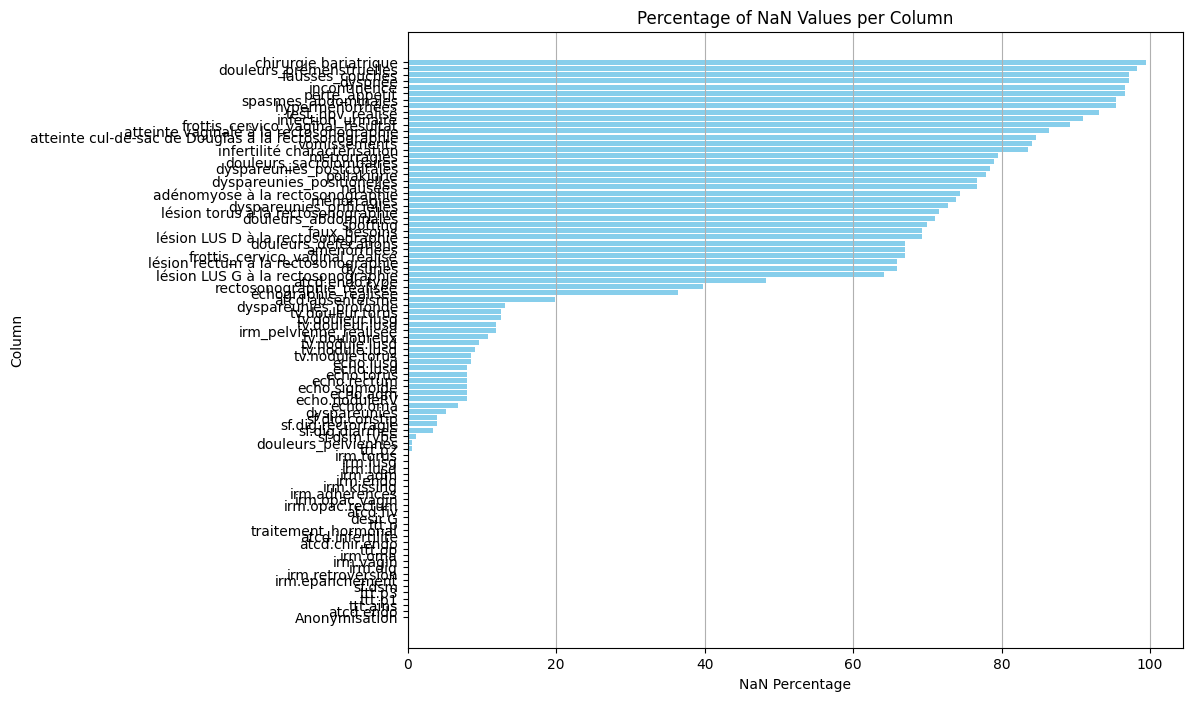

In [ ]:
# Tracer un graphique en barres
na_df_sorted_ascending = na_df.sort_values(by='NaN Percentage', ascending=True)
plt.figure(figsize=(10, 8))  # Ajuster la taille du graphique si nécessaire
plt.barh(na_df_sorted_ascending['Column'], na_df_sorted_ascending['NaN Percentage'], color='skyblue')
plt.xlabel('NaN Percentage')
plt.ylabel('Column')
plt.title('Percentage of NaN Values per Column')
plt.grid(True, axis='x')  # Ajouter une grille pour les axes si souhaité
plt.show()

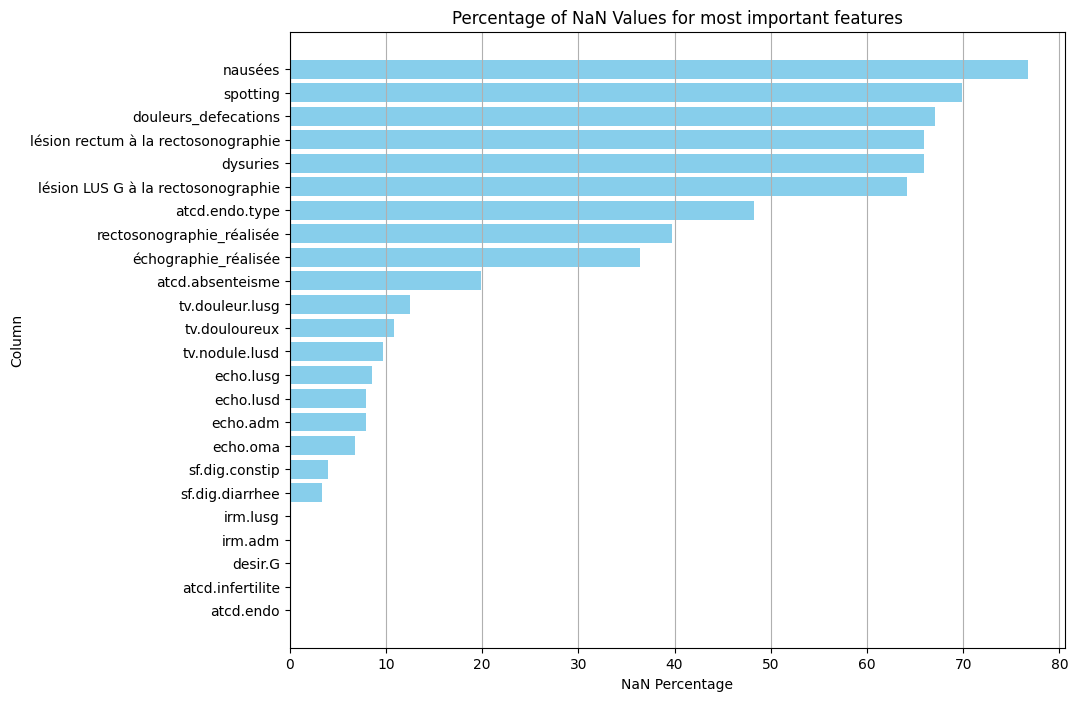

In [ ]:
# Note most important feautres = those that appear in top 10 of feature importances of model
features_important = ['imc', 'age', 'g', 'atcd.endo', 'atcd.endo.type', 'atcd.infertilite', 'atcd.absenteisme', 
                      'irm.adm', 'irm.lusg', 'echo.lusg', 'echo.lusd', 'echo.oma', 'echo.adm', 
                      'rectosonographie_réalisée', 'lésion LUS G à la rectosonographie', 'lésion rectum à la rectosonographie',
                      'échographie_réalisée', 'tv.douleur.lusg', 'tv.douloureux', 'tv.nodule.lusd', 
                      'nausées', 'douleurs_defecations', 'dysuries', 'sf.dig.diarrhee', 'spotting', 'sf.dig.constip', 'desir.G']
na_df_all = pd.DataFrame({'Column': na_percentage.index, 'NaN Percentage': na_percentage.values}).sort_values(by='NaN Percentage', ascending=True)
na_df_important_features = na_df_all.loc[na_df_all.Column.isin(features_important)]
plt.figure(figsize=(10, 8))  # Ajuster la taille du graphique si nécessaire
plt.barh(na_df_important_features['Column'], na_df_important_features['NaN Percentage'], color='skyblue')
plt.xlabel('NaN Percentage')
plt.ylabel('Column')
plt.title('Percentage of NaN Values for most important features')
plt.grid(True, axis='x')  # Ajouter une grille pour les axes si souhaité
plt.show()

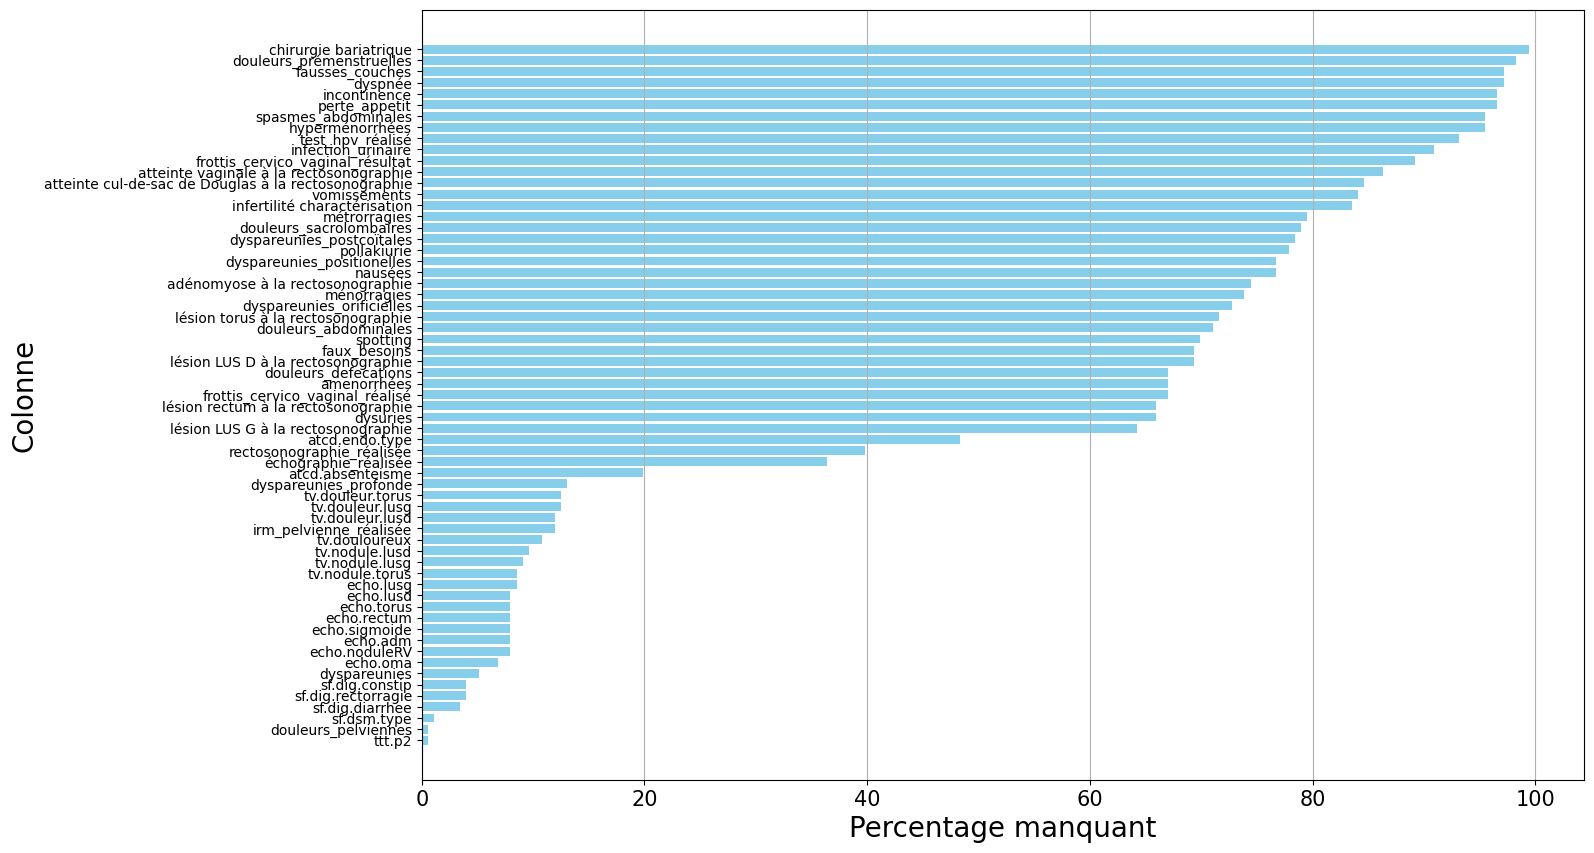

In [ ]:
# Filter the DataFrame to only include columns with NaN percentage > 0
na_df_sorted_ascending = na_df.sort_values(by='NaN Percentage', ascending=True)
na_df_filtered = na_df_sorted_ascending[na_df_sorted_ascending['NaN Percentage'] > 0]

# Plot a bar chart only for columns with NaN percentage > 0
plt.figure(figsize=(15, 10))
plt.barh(na_df_filtered['Column'], na_df_filtered['NaN Percentage'], color='skyblue')

# Add labels and title
plt.xlabel('Percentage manquant', fontsize=20)
plt.ylabel('Colonne', fontsize=20)
plt.title('')

# Rotate x-labels if necessary
plt.xticks(fontsize=15)

# Show the plot
plt.grid(True, axis='x')
plt.show()

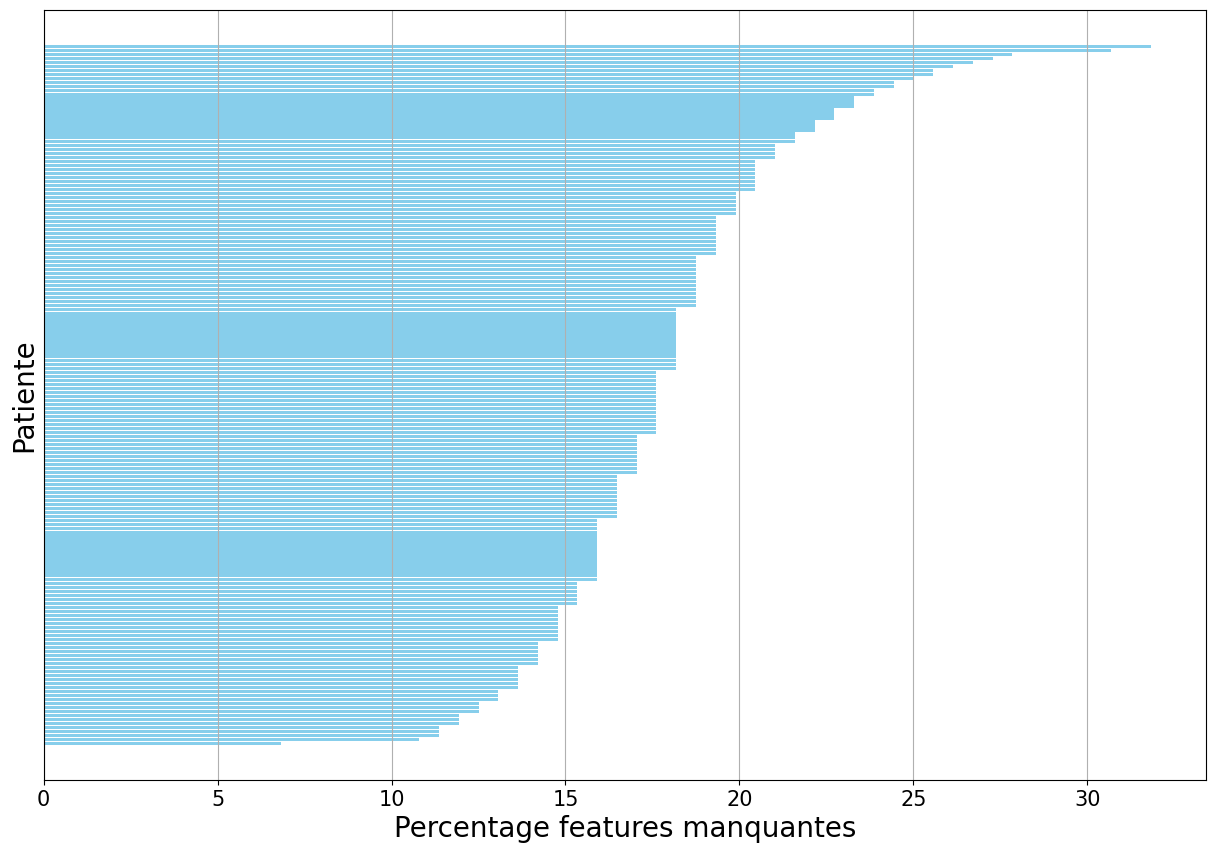

In [11]:
df_missing_per_patient = pd.DataFrame()
df_missing_per_patient['Anonymisation'] = df['Anonymisation']
df_missing_per_patient['nmissing'] = df.apply(lambda x: x.isna().sum(), axis=1)
df_missing_per_patient['perc_missing'] = (df_missing_per_patient['nmissing'] / df.shape[0]) * 100
df_missing_per_patient_sorted_ascending = df_missing_per_patient.sort_values(by='nmissing', ascending=True)

# Plot a bar chart only for columns with NaN percentage > 0
plt.figure(figsize=(15, 10))
plt.barh(df_missing_per_patient_sorted_ascending['Anonymisation'], df_missing_per_patient_sorted_ascending['perc_missing'], color='skyblue')

# Add labels and title
plt.xlabel('Percentage features manquantes', fontsize=20)
plt.ylabel('Patiente', fontsize=20)
plt.title('')

# Rotate x-labels if necessary
plt.xticks(fontsize=15)

# Show the plot
plt.grid(True, axis='x')
'''
frame1 = plt.gca()
frame1.axes.get_yaxis().set_visible(False)
'''
plt.gca().set_yticks([]) 
plt.show()

In [12]:
patients_max_20_perc_missing = list(df_missing_per_patient_sorted_ascending.loc[df_missing_per_patient_sorted_ascending.perc_missing<=20, 'Anonymisation'])

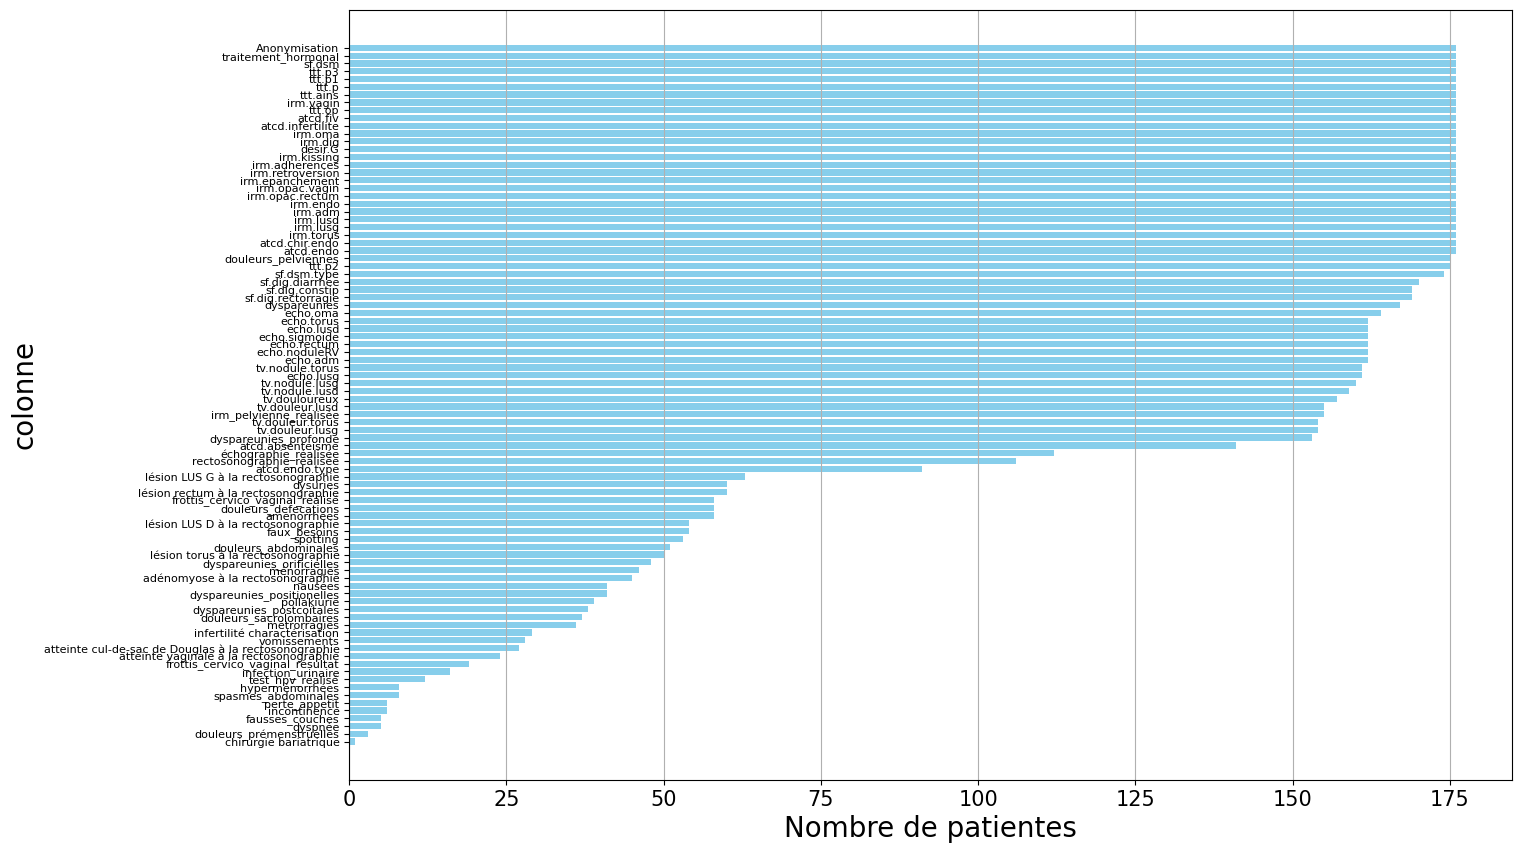

In [ ]:
df_npatients_per_feature = df.count().sort_values(ascending=True).reset_index().rename(columns={'index': 'feature', 0: 'ndata'})

# Plot a bar chart only for columns with NaN percentage > 0
plt.figure(figsize=(15, 10))
plt.barh(df_npatients_per_feature['feature'], df_npatients_per_feature['ndata'], color='skyblue')

# Add labels and title
plt.xlabel('Nombre de patientes', fontsize=20)
plt.ylabel('colonne', fontsize=20)
plt.title('')

plt.xticks(fontsize=15)
plt.yticks(fontsize=8)

# Show the plot
plt.grid(True, axis='x')
plt.show()

In [14]:
features_at_least_75_patients = list(df_npatients_per_feature.loc[df_npatients_per_feature.ndata >= 75, 'feature'])
features_at_least_75_patients = [f for f in features_at_least_75_patients if f!='Anonymisation']

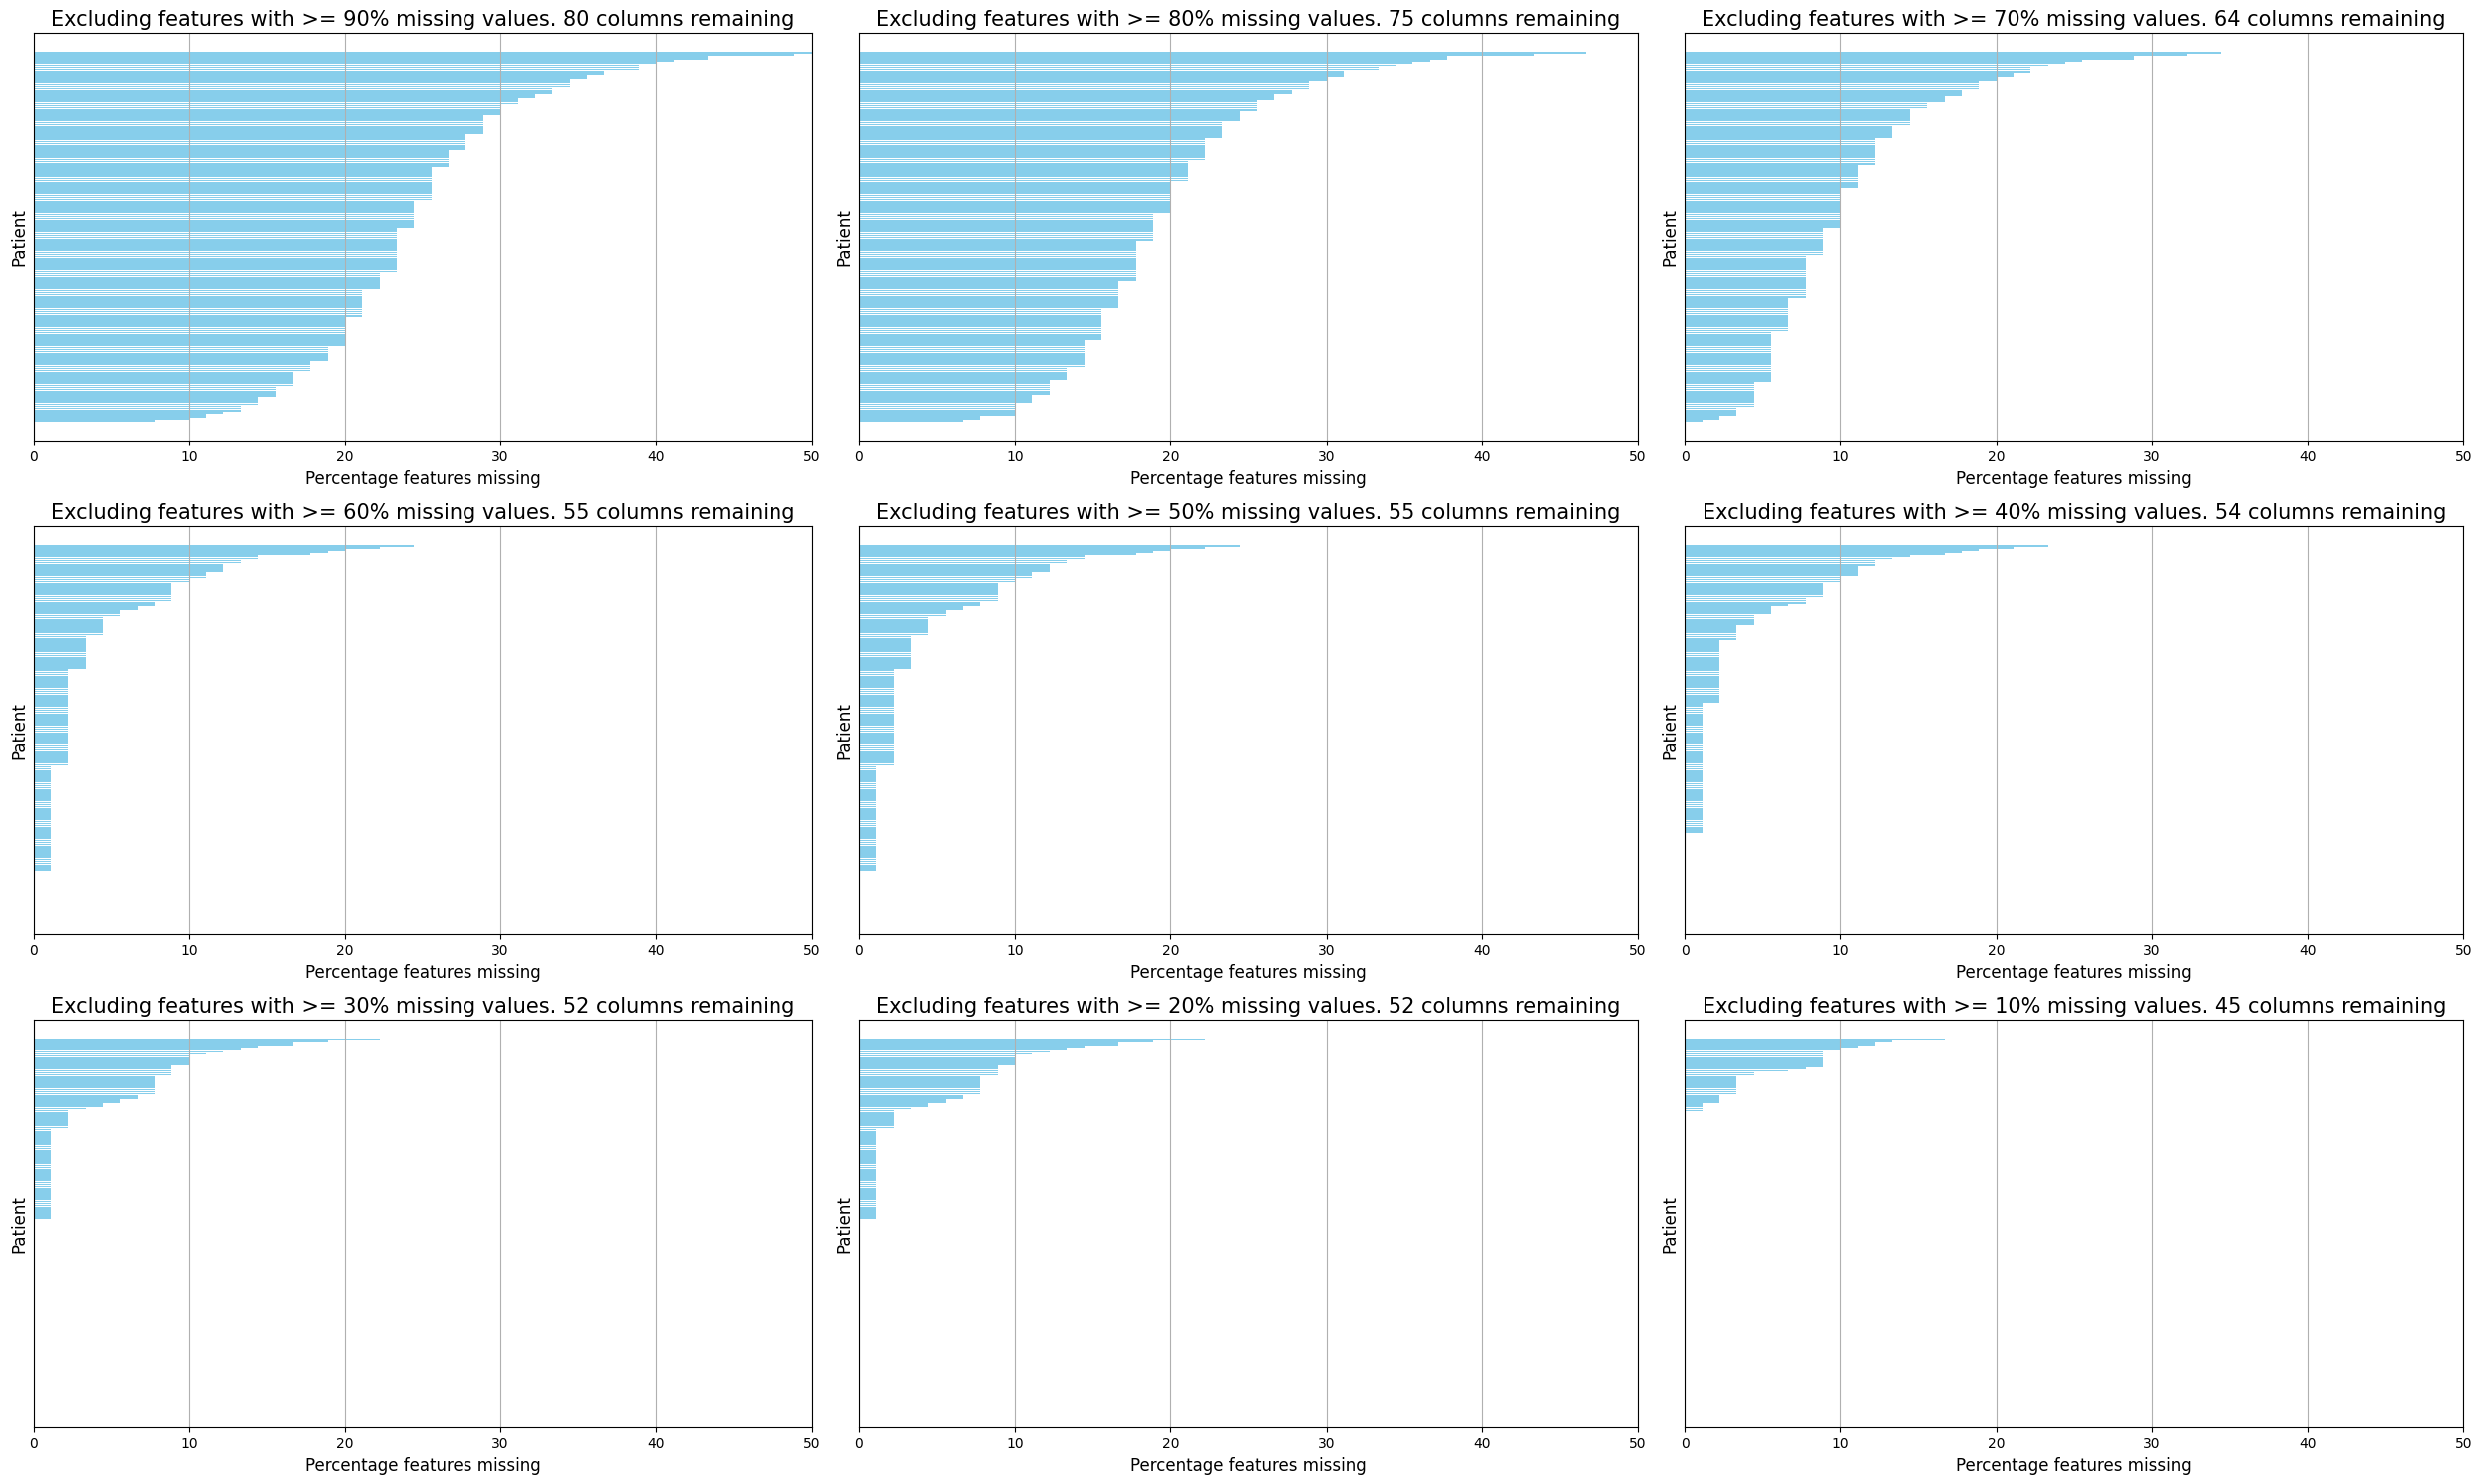

In [ ]:
# Calculer le pourcentage de NaN pour chaque colonne
na_percentage = df.isna().mean() * 100

# Créer un nouveau DataFrame avec les résultats
na_df = pd.DataFrame({
    'Column': na_percentage.index,
    'NaN Percentage': na_percentage.values
})

# Trier le DataFrame par pourcentage de NaN en ordre décroissant
na_df_sorted = na_df.sort_values(by='NaN Percentage', ascending=False)
na_df_filtered = na_df_sorted_ascending[na_df_sorted_ascending['NaN Percentage'] > 0]

# Step 1: Sort columns based on NaN percentage in descending order
sorted_na_columns = na_df_filtered.sort_values(by='NaN Percentage', ascending=False)['Column']
columns_no_missing = list(na_df_sorted_ascending.loc[na_df_sorted_ascending['NaN Percentage']==0, 'Column'])

# Step 2: Create the subplots
perc_remove_steps = [90, 80, 70, 60, 50, 40, 30, 20, 10]

fig, axes = plt.subplots(int(np.ceil(len(perc_remove_steps)/3)), 3, figsize=(25, 15))
axes = axes.flatten()

# Iterate over each subplot
for i, perc_remove in enumerate(perc_remove_steps):

    # Step 3: Discard the features with more than X% missing values
    na_df_sorted_ascending
    columns_to_keep = list(na_df_filtered.loc[na_df_filtered['NaN Percentage'] < perc_remove, 'Column'])
    
    # Create a new dataframe excluding the columns with most missing values
    df_filtered = df[columns_to_keep + ['Anonymisation']]
    n_columns_remaining = len(columns_to_keep) + len(columns_no_missing)

    # Recalculate missing values per row
    df_missing_per_patient_filtered = pd.DataFrame()
    df_missing_per_patient_filtered['Anonymisation'] = df_filtered['Anonymisation']
    df_missing_per_patient_filtered['nmissing'] = df_filtered.apply(lambda x: x.isna().sum(), axis=1)
    df_missing_per_patient_filtered['perc_missing'] = (df_missing_per_patient_filtered['nmissing'] / df.shape[1]) * 100
    df_missing_per_patient_filtered_sorted = df_missing_per_patient_filtered.sort_values(by='nmissing', ascending=True)

    # Step 4: Plot the percentage of missing values per row
    axes[i].barh(df_missing_per_patient_filtered_sorted['Anonymisation'], 
                 df_missing_per_patient_filtered_sorted['perc_missing'], 
                 color='skyblue')

    # Add labels and title to each subplot
    axes[i].set_xlabel('Percentage features missing', fontsize=12)
    axes[i].set_ylabel('Patient', fontsize=12)
    axes[i].set_title(f'Excluding features with >= {perc_remove}% missing values. {n_columns_remaining} columns remaining', fontsize=15)
    axes[i].set_xlim([0, 50])

    # Remove y-ticks and add grid
    axes[i].set_yticks([])
    axes[i].grid(True, axis='x')

for ax in axes:
    if not ax.has_data():  # Check if the axis has any data
        fig.delaxes(ax)    # Remove the empty axis

# Step 5: Adjust layout and show the plot
plt.tight_layout()
plt.show()



### Explore which variables are correlated

In [ ]:
# Calculate the correlation matrix
corr_matrix = df.set_index('Anonymisation').corr()

# Unstack the correlation matrix and reset the index to get a two-column DataFrame
corr_pairs = corr_matrix.unstack().reset_index()

# Rename columns for better readability
corr_pairs.columns = ['Column 1', 'Column 2', 'Correlation']

# Remove duplicate pairs by keeping only the lower triangle (where 'Column 1' != 'Column 2')
corr_pairs = corr_pairs[corr_pairs['Column 1'] != corr_pairs['Column 2']]

# Sort by the absolute value of correlation in descending order
sorted_corr_pairs = corr_pairs.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

# Display the sorted correlation pairs
sorted_corr_pairs

,Column 1,Column 2,Correlation
0,incontinence,douleurs_defecations,1.0
1,dyspareunies_profonde,dyspareunies_orificielles,1.0
2,lésion LUS D à la rectosonographie,atteinte cul-de-sac de Douglas à la rectosonog...,1.0
3,dyspareunies_postcoïtales,dyspareunies_profonde,1.0
4,dyspnée,vomissements,1.0
...,...,...,...
7827,traitement_hormonal,hyperménorrhées,NaN
7828,traitement_hormonal,spasmes_abdominales,NaN
7829,traitement_hormonal,fausses_couches,NaN
7830,traitement_hormonal,chirurgie bariatrique,NaN


## ML : 

### Preparation

In [17]:
# Drop all columns with percentage missing values higher than a given threshold
features_select = 'all'  # 'by_perc_missing'
if features_select == 'all':
    thresh_missing = 100
    
    # Calculer le pourcentage de NaN pour chaque colonne
    na_percentage = df.isna().mean() * 100

    # Créer un nouveau DataFrame avec les résultats
    na_df = pd.DataFrame({
        'Column': na_percentage.index,
        'NaN Percentage': na_percentage.values
    })

    # Trier le DataFrame par pourcentage de NaN en ordre décroissant
    na_df_sorted = na_df.sort_values(by='NaN Percentage', ascending=False)
    na_df_filtered = na_df_sorted[na_df_sorted['NaN Percentage'] > 0]

    # Step 1: Sort columns based on NaN percentage in descending order
    sorted_na_columns = na_df_filtered.sort_values(by='NaN Percentage', ascending=False)['Column']
    columns_no_missing = list(na_df_sorted.loc[na_df_sorted['NaN Percentage']==0, 'Column'])
    columns_above_threshold = na_percentage[na_percentage >= thresh_missing].index.tolist()
    columns_to_keep = list(df.drop(columns_above_threshold, axis=1).columns)
    if 'Anonymisation' not in columns_to_keep:
        columns_to_keep = columns_to_keep + ['Anonymisation']
    print(f'{len(columns_to_keep)} columns remaining')

else:
    columns_to_keep = list(df.columns)

90 columns remaining


In [18]:
# Try including different patients, for example filtering out those with many missing values
patients_select = 'by_perc_missing'   #'by_perc_missing'
if patients_select == 'by_perc_missing':
    max_perc_missing = 20
    if features_select == 'by_perc_missing':
        df = df[columns_to_keep]
    # Recompute percentage missing df because features might have been rejected
    df_missing_per_patient = pd.DataFrame()
    df_missing_per_patient['Anonymisation'] = df['Anonymisation']
    df_missing_per_patient['nmissing'] = df.apply(lambda x: x.isna().sum(), axis=1)
    df_missing_per_patient['perc_missing'] = (df_missing_per_patient['nmissing'] / df.shape[0]) * 100
    df_missing_per_patient_sorted_ascending = df_missing_per_patient.sort_values(by='nmissing', ascending=True)
    patients_select = list(df_missing_per_patient_sorted_ascending.loc[df_missing_per_patient_sorted_ascending.perc_missing<=max_perc_missing, 'Anonymisation'])
    df = df.loc[df['Anonymisation'].isin(patients_select)]
    print(f'{len(patients_select)} patients remaining')

139 patients remaining


In [19]:
if data_select == 'original':
    features = df.copy()
    features_chir_ONE = pd.get_dummies(features.loc[:,'chir'], prefix='chir')
    features_dsptype_ONE = pd.get_dummies(features.loc[:,'sf.dsp.type'].replace(0, 'aucun'), prefix='dsp.type')
    df = pd.concat([features.drop('chir', axis=1).drop('sf.dsp.type', axis=1), features_chir_ONE, features_dsptype_ONE], axis=1)

In [ ]:
if data_select != 'original':
    df_with_target = pd.merge(df, recueil_imc, on=['Anonymisation'])
else:
    df_with_target = df.copy()
endometriose = df_with_target.loc[:,['anapath.lusd','anapath.lusg','anapath.torus']].sum(axis=1).apply(lambda x: Binarisation(x))
df_with_target['endometriose'] = endometriose
df_with_target.drop(['anapath.lusd','anapath.lusg','anapath.torus'], axis=1, inplace=True)

df_with_target.head()

,Anonymisation,atcd.endo,atcd.endo.type,atcd.chir.endo,atcd.infertilite,atcd.fiv,desir.G,atcd.absenteisme,ttt.op,ttt.p,...,atteinte vaginale à la rectosonographie,atteinte cul-de-sac de Douglas à la rectosonographie,lésion rectum à la rectosonographie,test_hpv_réalisé,traitement_hormonal,age,imc,g,p,endometriose
0,AA-071,0,NaN,0,0,0,0,1.0,0,1,...,NaN,NaN,NaN,1.0,0,35,26.3,5,3,1
1,AB-067,0,2.0,0,0,0,0,0.0,0,1,...,NaN,NaN,NaN,NaN,1,31,27.4,4,2,0
2,AC-131,0,2.0,0,0,0,0,1.0,1,1,...,NaN,NaN,NaN,NaN,1,27,16.4,0,0,0
3,AE-062,1,2.0,1,1,1,1,0.0,0,0,...,0.0,0.0,0.0,NaN,0,39,24.2,1,1,1
4,AM-023,0,2.0,0,1,0,1,0.0,1,0,...,NaN,NaN,1.0,NaN,1,35,19.0,0,0,1


In [21]:
# Replace missing values with '0' (assuming absence of symptoms for example)
#df_with_target = df_with_target.fillna(0)
df_with_target.set_index('Anonymisation', inplace=True)

endometriose = df_with_target['endometriose']
features = df_with_target.drop(['endometriose'], axis=1)

In [22]:
if data_select == 'original':
    # On enlève les colonnes correlées : 
    liste_to_drop = ['p','atcd.chir.endo','atcd.infertilite','sf.dsm','sf.dsp','ef.hormone.dsm','echo.oma','irm.xr']
    for col in liste_to_drop:
        features.drop(col, axis=1, inplace=True)

In [23]:
# split
X_train, X_test, y_train, y_test = train_test_split(features, endometriose, random_state=42, stratify=endometriose)

In [24]:
## Init Metrics :
scorer = make_scorer(custom_metric, greater_is_better=True)
mix_recall = make_scorer(mix_sensi_speci, greater_is_better=True)
sensibilite = make_scorer(sensi, greater_is_better=True)
specificite = make_scorer(speci, greater_is_better=True)
scorers = { 'speci': specificite, 'sensi' : sensibilite}

In [37]:
seed = 42
tree_1 = XGBClassifier(random_state=seed)
test_cv = cross_validate(tree_1, X_train, y_train, cv=5, scoring=scorers, return_estimator =True)

print('sensi : ',round(test_cv['test_sensi'].mean(), 2))
print('speci : ',round(test_cv['test_speci'].mean(),2))

AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [23]:
print(f'{df.shape[0]} patients')
print(f'{df.shape[1]} features')

139 patients
90 features


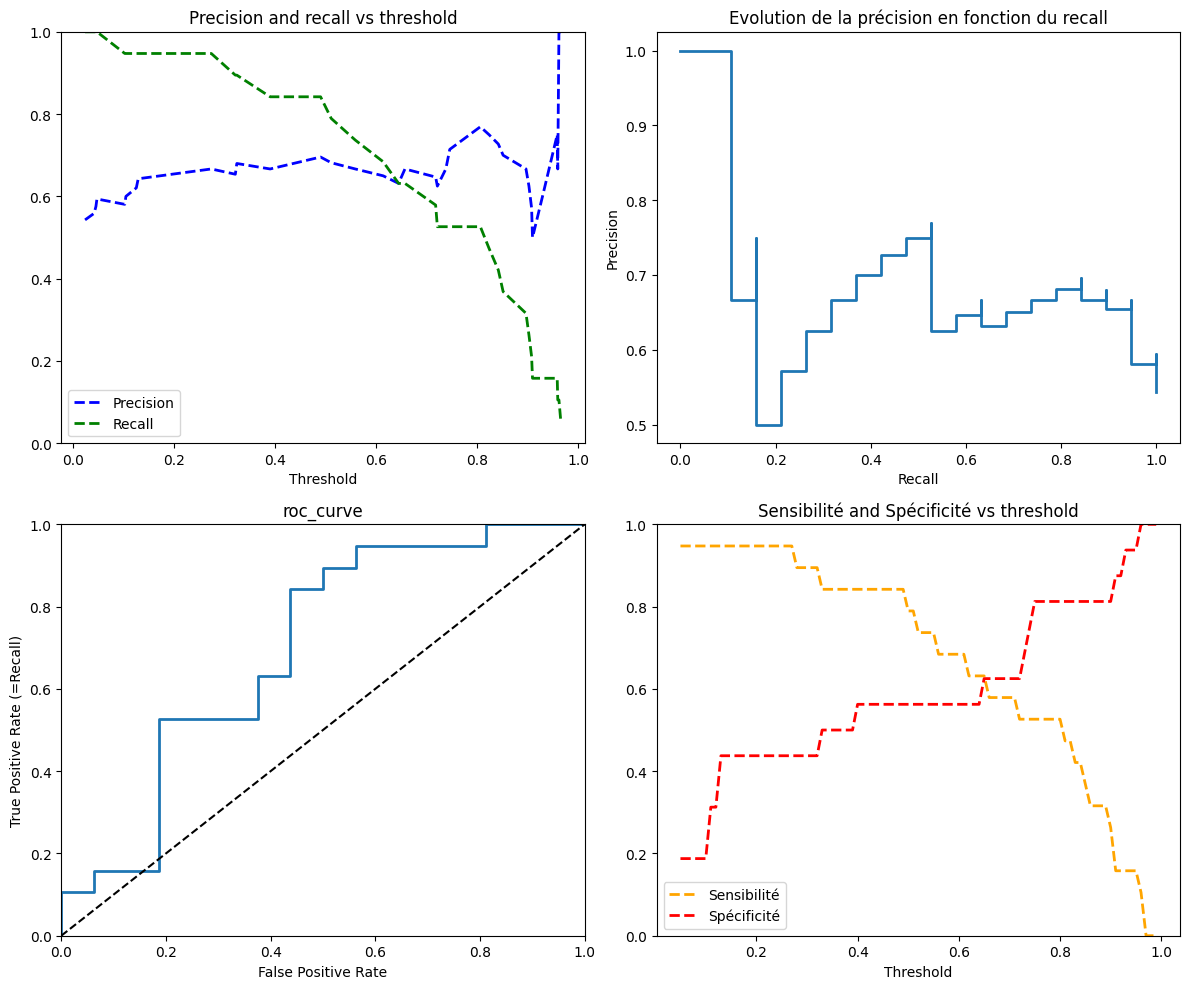

################ Priorité = receuil ################
threshold = 0,5
Sensibilité :  0.7894736842105263
Spécificité :  0.5625
_________________________________________________________
Best threshold : 0.75
Sensibilité : 0.5263157894736842
Spécificité : 0.8125


In [24]:
tree_BL = XGBClassifier(random_state=seed, )
tree_BL.fit(X_train, y_train)
pred_BL = tree_BL.predict(X_test)
model_to_plot(tree_BL, X_test, y_test)
resultat_BL = pd.DataFrame(pd.Series(scores(y_test, pred_BL)), columns=['XGB_BL_sensi'])
if data_select == 'original':
    print(f'################ Données receuil origine ################')
else:
    print(f'################ Priorité = {data_select} ################')
print('threshold = 0,5')
print('Sensibilité : ', resultat_BL.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_BL.loc['specificité','XGB_BL_sensi'])
dict_ = from_model_to_bst_trhld(tree_BL, X_test, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_['best_threshold'])
print('Sensibilité :', dict_['scores']['sensibilite'])
print('Spécificité :', dict_['scores']['specificité'])

                                               feature  importance
56                                                age        53.0
57                                                imc        43.0
32                                   irm.retroversion        22.0
48                               échographie_réalisée        21.0
43                                            nausées        16.0
24                                          echo.lusd        15.0
58                                                  g        15.0
15                                     sf.dig.constip        15.0
37                                           dysuries        14.0
55                                traitement_hormonal        13.0
10                                douleurs_pelviennes        12.0
39                                        amenorrhées        12.0
0                                           atcd.endo        11.0
17                                      tv.douloureux         9.0
2        

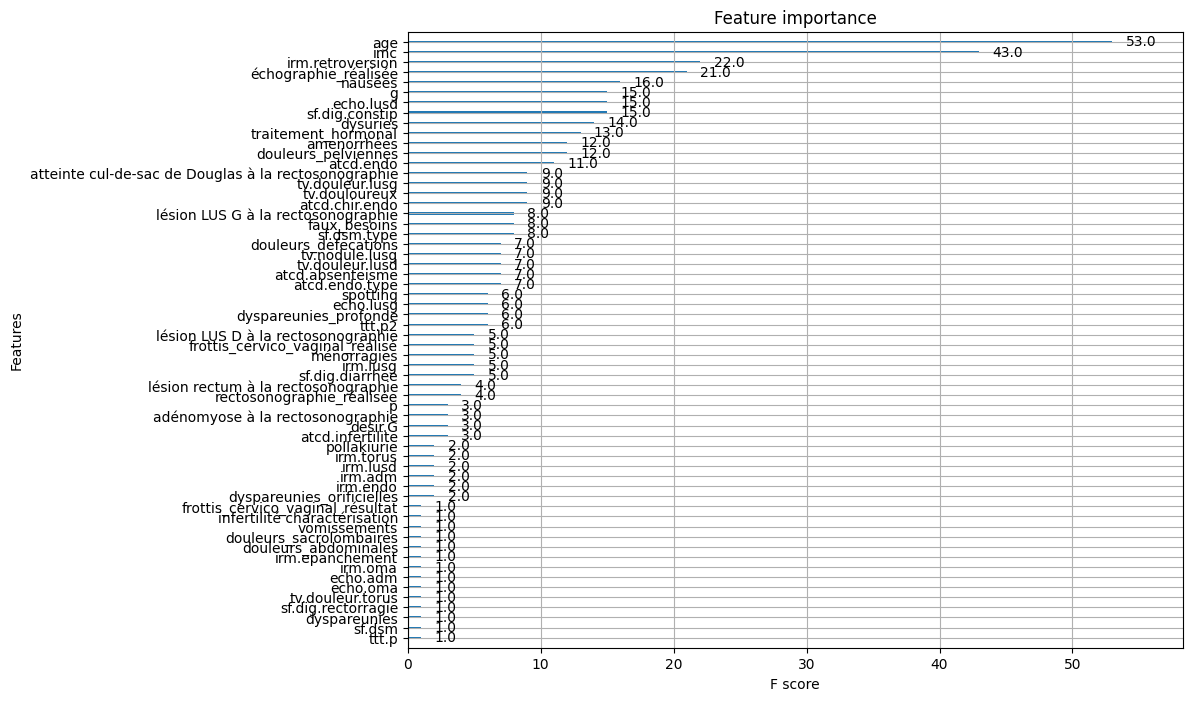

In [25]:
# Show feature importance
xgb_fea_imp=pd.DataFrame(list(tree_BL.get_booster().get_fscore().items()),
columns=['feature','importance']).sort_values('importance', ascending=False)
print('',xgb_fea_imp)

ax = plot_importance(tree_BL, )
ax.figure.set_size_inches(10,8)

### Systematically vary the features and patients included

In [26]:
# Features and patients with more than X% missing data will be excluded
cutoffs_features = ['none', 50, 40, 30, 20, 10]
cutoffs_patients = [50, 40, 30, 20, 10]

# Create an empty DataFrame with the specified rows and columns
df_npatients = pd.DataFrame(index=cutoffs_features, columns=cutoffs_patients)
df_nfeatures = pd.DataFrame(index=cutoffs_features, columns=cutoffs_patients)
df_sensitivities = pd.DataFrame(index=cutoffs_features, columns=cutoffs_patients)
df_specificities = pd.DataFrame(index=cutoffs_features, columns=cutoffs_patients)
df_best_thresholds = pd.DataFrame(index=cutoffs_features, columns=cutoffs_patients)

for cutoff_feature in cutoffs_features:
    for cutoff_patients in cutoffs_patients:
        df = df_orig.copy()
        # Drop all columns with percentage missing values higher than a given threshold

        if cutoff_feature == 'none':
            columns_to_keep = list(df.columns)
        else:
            # Calculer le pourcentage de NaN pour chaque colonne
            na_percentage = df.isna().mean() * 100

            # Créer un nouveau DataFrame avec les résultats
            na_df = pd.DataFrame({
                'Column': na_percentage.index,
                'NaN Percentage': na_percentage.values
            })

            # Trier le DataFrame par pourcentage de NaN en ordre décroissant
            na_df_sorted = na_df.sort_values(by='NaN Percentage', ascending=False)
            na_df_filtered = na_df_sorted_ascending[na_df_sorted_ascending['NaN Percentage'] > 0]

            # Step 1: Sort columns based on NaN percentage in descending order
            sorted_na_columns = na_df_filtered.sort_values(by='NaN Percentage', ascending=False)['Column']
            columns_no_missing = list(na_df_sorted_ascending.loc[na_df_sorted_ascending['NaN Percentage']==0, 'Column'])
            columns_above_threshold = na_percentage[na_percentage >= cutoff_feature].index.tolist()
            columns_to_keep = list(df.drop(columns_above_threshold, axis=1).columns)
            if 'Anonymisation' not in columns_to_keep:
                columns_to_keep = columns_to_keep + ['Anonymisation']
        df_nfeatures.loc[cutoff_feature, cutoff_patients] = len(columns_to_keep)


        # Try including different patients, for example filtering out those with many missing values
        # Recompute percentage missing df because features might have been rejected
        df = df[columns_to_keep]
        df_missing_per_patient = pd.DataFrame()
        df_missing_per_patient['Anonymisation'] = df['Anonymisation']
        df_missing_per_patient['nmissing'] = df.apply(lambda x: x.isna().sum(), axis=1)
        df_missing_per_patient['perc_missing'] = (df_missing_per_patient['nmissing'] / df.shape[0]) * 100
        df_missing_per_patient_sorted_ascending = df_missing_per_patient.sort_values(by='nmissing', ascending=True)
        patients_select = list(df_missing_per_patient_sorted_ascending.loc[df_missing_per_patient_sorted_ascending.perc_missing<=cutoff_patients, 'Anonymisation'])
        df = df.loc[df['Anonymisation'].isin(patients_select)]
        df_npatients.loc[cutoff_feature, cutoff_patients] = len(patients_select)
        
        df_with_target = pd.merge(df, recueil_imc, on=['Anonymisation'])
        endometriose = df_with_target.loc[:,['anapath.lusd','anapath.lusg','anapath.torus']].sum(axis=1).apply(lambda x: Binarisation(x))
        df_with_target['endometriose'] = endometriose
        df_with_target.drop(['anapath.lusd','anapath.lusg','anapath.torus'], axis=1, inplace=True)
        
        # Replace missing values with '0' (assuming absence of symptoms for example)
        #df_with_target = df_with_target.fillna(0)
        df_with_target.set_index('Anonymisation', inplace=True)

        endometriose = df_with_target['endometriose']
        features = df_with_target.drop(['endometriose'], axis=1)

        # On enlève les colonnes correlées : 
        liste_to_drop = ['p','atcd.chir.endo','atcd.infertilite','sf.dsm','sf.dsp','ef.hormone.dsm','echo.oma','irm.xr']
        for col in liste_to_drop:
            if col in features.columns:
                features.drop(col, axis=1, inplace=True)
            
        # split
        if features.shape[0] <= 10:
            df_sensitivities.loc[cutoff_feature, cutoff_patients] = np.nan
            df_specificities.loc[cutoff_feature, cutoff_patients] = np.nan
            df_best_thresholds.loc[cutoff_feature, cutoff_patients] = np.nan
        else:
            X_train, X_test, y_train, y_test = train_test_split(features, endometriose, random_state=42, stratify=endometriose)

            tree_BL = XGBClassifier(random_state=seed, )
            tree_BL.fit(X_train, y_train)
            pred_BL = tree_BL.predict(X_test)
            resultat_BL = pd.DataFrame(pd.Series(scores(y_test, pred_BL)), columns=['XGB_BL_sensi'])
            dict_ = from_model_to_bst_trhld(tree_BL, X_test, y_test)
            df_sensitivities.loc[cutoff_feature, cutoff_patients] = dict_['scores']['sensibilite']
            df_specificities.loc[cutoff_feature, cutoff_patients] = dict_['scores']['specificité']
            df_best_thresholds.loc[cutoff_feature, cutoff_patients] = dict_['best_threshold']

print('N patients:')
print(df_npatients)
print('N features:')
print(df_nfeatures)
print('Sensitivities:')
print(df_sensitivities)
print('\nSpecificities:')
print(df_specificities)

N patients:
       50   40   30   20   10
none  176  176  174  139    1
50    176  176  176  176  173
40    176  176  176  176  174
30    176  176  176  176  175
20    176  176  176  176  175
10    176  176  176  176  176
N features:
      50  40  30  20  10
none  90  90  90  90  90
50    55  55  55  55  55
40    54  54  54  54  54
30    52  52  52  52  52
20    52  52  52  52  52
10    45  45  45  45  45
Sensitivities:
            50        40        30        20        10
none  0.304348  0.304348       0.5  0.631579       NaN
50     0.26087   0.26087   0.26087   0.26087  0.458333
40    0.217391  0.217391  0.217391  0.217391  0.208333
30    0.304348  0.304348  0.304348  0.304348  0.291667
20    0.304348  0.304348  0.304348  0.304348  0.291667
10    0.217391  0.217391  0.217391  0.217391  0.217391

Specificities:
            50        40        30        20        10
none  0.809524  0.809524       0.8     0.875       NaN
50    0.904762  0.904762  0.904762  0.904762      0.85
40    0.80

### Which patients are the hardest to predict?

In [27]:
threshold = 0.1
predict_proba = pd.DataFrame(tree_BL.predict_proba(X_test))
predict_proba_temp = (predict_proba.iloc[:,1]>threshold).apply(lambda x: round(x,0))
patients_false_negatives = list(y_test[(y_test.values == 1) & (predict_proba_temp.values == 0)].index)
patients_false_positives = list(y_test[(y_test.values == 0) & (predict_proba_temp.values == 1)].index)

In [34]:
X_test.loc[list(set(X_test.reset_index()['Anonymisation']).intersection(set(patients_false_negatives)))][list(set(xgb_fea_imp.head(15)['feature']).intersection(set(X_test.columns)))] #list(xgb_fea_imp.head(15)['feature'])

,irm.retroversion,age,echo.lusd,traitement_hormonal,atcd.endo,sf.dig.constip,imc,g,douleurs_pelviennes
Anonymisation,,,,,,,,,
BC-154,0,26,0.0,1,0,1.0,28.1,1,1.0
SC-109,1,32,0.0,0,1,1.0,24.0,1,1.0
PL-153,1,30,0.0,1,1,0.0,22.7,1,0.0


In [33]:
X_test.loc[list(set(X_test.reset_index()['Anonymisation']).intersection(set(patients_false_positives)))][list(set(xgb_fea_imp.head(15)['feature']).intersection(set(X_test.columns)))] #list(xgb_fea_imp.head(15)['feature'])

,irm.retroversion,age,echo.lusd,traitement_hormonal,atcd.endo,sf.dig.constip,imc,g,douleurs_pelviennes
Anonymisation,,,,,,,,,
ML-069,0,21,NaN,1,0,0.0,21.4,0,1.0
TJ-090,0,37,0.0,1,1,0.0,26.0,1,0.0
BR-043,0,38,0.0,1,0,0.0,19.3,4,1.0
SS-162,0,38,0.0,1,1,1.0,24.3,1,1.0
ML-170,0,35,0.0,0,0,0.0,19.2,1,0.0
GM-113,0,21,1.0,0,0,0.0,17.2,0,1.0
TC-198,0,27,1.0,1,0,0.0,35.8,2,0.0
NA-144,0,33,1.0,0,0,1.0,20.3,1,1.0
LS-066,0,31,0.0,0,0,0.0,25.1,0,0.0
